In [99]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# NLTK
from nltk.corpus import stopwords
import nltk;

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# spacy for lemmatization
import spacy

#Topic Modeling 
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize;

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from helper_functions.utils import Utils
from config import common_stop_words

In [100]:
utilities = Utils()
so_posts = utilities.dataset_importer("../data/cleaned/cleaned_text.csv", "cleaned_text")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\muthu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
cleaned_text = so_posts["cleaned_text"]
cleaned_text.head()

0    use clustermanager google render lot place map...
1    way access blue flash light appear google map ...
2    consider follow try get current time zone use ...
3    try figure setup navigation image map web brow...
4    try get list address search address edittext u...
Name: cleaned_text, dtype: object

In [102]:
stop_words = stopwords.words('english')
stop_words.extend(['00', 'from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across', 'want', 'need', 'thank', 'know', 'like', 'use', 'try', 'help', 'work'])
stop_words.extend(common_stop_words)

# LSI

In [103]:
NUM_TOPICS = 10

# Converting the document to a matrix of token counts

vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(cleaned_text.values.astype('U'))
 
# Build a Latent Semantic Indexing Model using SVD

lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)

(30917, 10)


# LDA

In [104]:
# LDA

so_posts["cleaned_text"] = so_posts["cleaned_text"].astype(str)
# Convert to list
df = so_posts.cleaned_text.values.tolist()

df = [re.sub('\S*@\S*\s?', '', sent) for sent in df]

# Remove new line characters
df = [re.sub('\s+', ' ', sent) for sent in df]

# Remove distracting single quotes
df = [re.sub("\'", "", sent) for sent in df]

pprint(df[:1])

['use clustermanager google render lot place map problem might place cluster '
 'renderer become extremely slow sometimes take second expand collapse cluster '
 'old cluster result still visible screen order optimize want show markers '
 'visible user take marker list filter markers outside visible region map '
 'however cause reclustering span map odd effect would like filter place '
 'visible region around bigger actual one calculate region visibleregion '
 'object get google map api']


In [105]:
df = [re.sub("-", " ", sent) for sent in df]
df = [re.sub(":", "", sent) for sent in df]

In [106]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df_words = list(sent_to_words(df))

In [107]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(df_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [108]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [109]:
# Remove Stop Words

data_words_nostops = remove_stopwords(df_words)

# Form Bigrams

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [110]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [111]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[11:12]]

[[('api', 3),
  ('map', 4),
  ('object', 1),
  ('way', 1),
  ('figure', 2),
  ('image', 1),
  ('look', 1),
  ('position', 1),
  ('phone', 1),
  ('randomly', 1),
  ('mode', 1),
  ('tell', 2),
  ('happen', 1),
  ('good', 1),
  ('high', 1),
  ('set', 1),
  ('analysis', 1),
  ('appropriate', 1),
  ('available', 1),
  ('bitmap', 1),
  ('charge', 2),
  ('close', 1),
  ('contrast', 1),
  ('corner', 1),
  ('create', 1),
  ('fragile', 1),
  ('ideally', 1),
  ('intersection', 6),
  ('label', 1),
  ('latlon', 2),
  ('manage', 1),
  ('mobile', 1),
  ('nearby', 1),
  ('normal', 1),
  ('output', 1),
  ('payment', 1),
  ('point', 2),
  ('projection', 1),
  ('push', 1),
  ('quite', 1),
  ('radius', 1),
  ('road', 1),
  ('route', 3),
  ('select', 1),
  ('snap_road', 1),
  ('style', 1),
  ('turn', 1),
  ('upcoming', 1),
  ('version', 1),
  ('well', 1),
  ('world', 1)]]

In [112]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# HDP

In [113]:
from gensim.models import CoherenceModel, HdpModel

In [114]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [115]:
hdptopics = hdpmodel.show_topics(formatted=False)

# NMF

In [116]:
raw_documents = so_posts["cleaned_text"].str.strip()
raw_documents= raw_documents.str.lower()
raw_documents = raw_documents.tolist()
raw_doc1 = [i.split() for i in raw_documents]

In [117]:
from sklearn.feature_extraction.text import CountVectorizer
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = stop_words, min_df = 20) #custom_stop_words
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 30917 X 2499 document-term matrix


In [118]:
terms = vectorizer.get_feature_names_out()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 2499 distinct terms


In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words= stop_words, min_df = 20) #custom_stop_words
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 30917 X 2499 TF-IDF-normalized document-term matrix


In [120]:
k = 10
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

In [121]:
import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

In [122]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )

Topic 01: map, google, android, app, application, display, zoom, load, view, open
Topic 02: location, current, user, update, code, change, time, button, method, app
Topic 03: marker, markers, click, add, image, custom, info, cluster, window, code
Topic 04: error, code, file, follow, manifest, run, logcat, add, project, xml
Topic 05: gps, turn, enable, coordinate, app, network, device, android, phone, provider
Topic 06: latitude, longitude, value, address, code, place, coordinate, database, lat, return
Topic 07: fragment, activity, class, map, layout, button, xml, click, view, main
Topic 08: point, draw, route, distance, line, polyline, path, calculate, coordinate, destination
Topic 09: service, update, play, app, run, background, start, google, stop, activity
Topic 10: api, key, google, android, place, generate, sha, console, debug, project


# Comparison

In [123]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=id2word)
lsitopics = lsimodel.show_topics(formatted=False)

In [124]:
ldatopics = lda_model.show_topics(formatted=False)

In [126]:
nmf_topics = descriptors

In [127]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]



In [128]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

nmf_coherence = CoherenceModel(topics=nmf_topics, texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

In [129]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(12,12))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

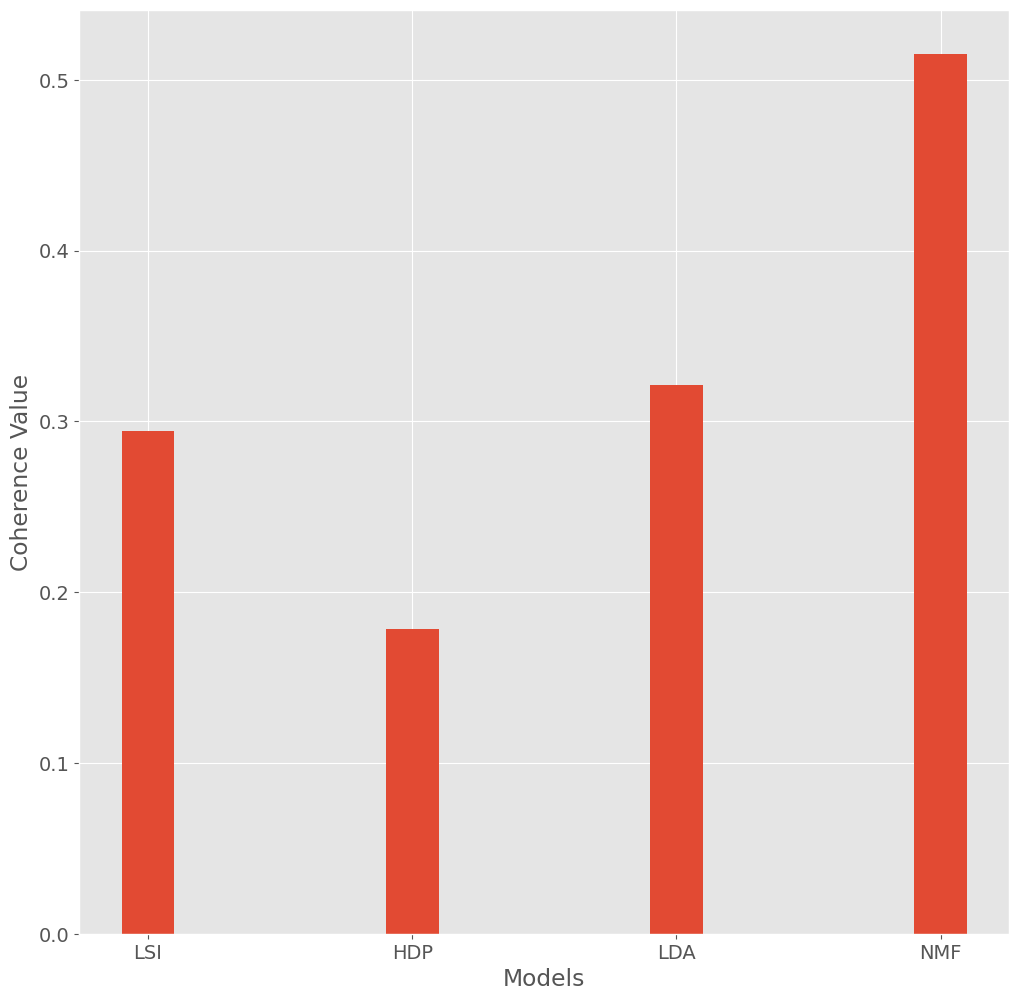

In [130]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, nmf_coherence],
                   ['LSI', 'HDP', 'LDA', 'NMF'])

In [131]:
coherence_comparison = [lsi_coherence, hdp_coherence, lda_coherence, nmf_coherence]

In [132]:
coherence_comparison

[0.29426265119819633,
 0.1786031480675486,
 0.32131551882824344,
 0.5153169453525057]